In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


# Importing Libraries 

In [2]:
import matplotlib.pyplot as plt     
import seaborn as sns               
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, ShuffleSplit,GridSearchCV,RandomizedSearchCV
    
from sklearn.tree import DecisionTreeClassifier      
from sklearn.pipeline import Pipeline                
    
from sklearn.decomposition import PCA                
from sklearn.svm import SVC,LinearSVC 

from sklearn.naive_bayes import GaussianNB           
from sklearn.neighbors import KNeighborsClassifier   

from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,StandardScaler

from sklearn.feature_selection import SelectKBest,chi2,RFE
from sklearn import metrics

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.compose import ColumnTransformer


from scipy.stats import uniform
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix,f1_score,accuracy_score,mean_squared_error,make_scorer
from sklearn.impute import KNNImputer

from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,VotingClassifier,RandomForestClassifier,StackingClassifier,BaggingClassifier

from sklearn.preprocessing import PolynomialFeatures,StandardScaler,MaxAbsScaler,RobustScaler

from xgboost import XGBClassifier

# DATA LOADING & EDA

In [3]:
#Reading train data and storing in data
data = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
data.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


**Exploring Train Dataset**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


In [5]:
data.describe()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
count,162758,162758,162758,156311,162758
unique,16812,4482,2,155071,2
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Parental Content Review,POSITIVE
freq,708,962,113189,29,108761


In [6]:
data.isnull().sum()

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

In [7]:
data.shape

(162758, 5)

**Loading and exploring movies dataset**

In [8]:
# loading movies dataset
md=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')
# md.head()

In [9]:
md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


In [10]:
md.isnull().sum()

movieid                      0
title                        0
audienceScore            70010
rating                  129267
ratingContents          129267
releaseDateTheaters     112485
releaseDateStreaming     63838
runtimeMinutes           13827
genre                    11083
originalLanguage         13858
director                     0
boxOffice               128515
distributor             120253
soundType               127341
dtype: int64

In [11]:
md.describe()

,audienceScore,runtimeMinutes
count,73248.000000,129431.000000
mean,55.674967,93.708578
std,24.553648,28.129175
min,0.000000,1.000000
25%,37.000000,84.000000
50%,57.000000,92.000000
75%,76.000000,103.000000
max,100.000000,2700.000000


**Loading and exploring Test dataset**

In [12]:
test_data=pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
test_data.head()

,movieid,reviewerName,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...


In [13]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


In [14]:
test_data.describe()

,movieid,reviewerName,isTopCritic,reviewText
count,55315,55315,55315,52805
unique,16786,4495,2,52686
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Parental Content Review
freq,230,428,38428,12


In [15]:
test_data.isnull().sum()

movieid            0
reviewerName       0
isTopCritic        0
reviewText      2510
dtype: int64

In [16]:
data.shape,test_data.shape,md.shape

((162758, 5), (55315, 4), (143258, 14))

# merging movie and train dataset

In [17]:
md = md.drop_duplicates(subset = 'movieid')

In [18]:
merge=pd.merge(data,md,on="movieid",how="left")
mer_ts=pd.merge(test_data,md,on="movieid",how="left")


In [19]:
merge.shape
mer_ts.shape

(55315, 17)

In [20]:
merge.boxOffice.unique()

array([nan, '$115.7M', '$7.6M', ..., '$210.0K', '$111.2K', '$799.4K'],
      dtype=object)

Here we can change boxoffice column to float 

In [21]:
# Step 1: Remove currency symbols and non-numeric characters
merge['boxOffice'] = merge['boxOffice'].str.replace(r'[^\d.]', '', regex=True)

# Step 2: Handle missing values (convert NaN to 0)
merge['boxOffice'].fillna('0', inplace=True)

# Step 3: Convert to float
merge['boxOffice'] = merge['boxOffice'].astype(float)


# Step 1: Remove currency symbols and non-numeric characters
mer_ts['boxOffice'] = mer_ts['boxOffice'].str.replace(r'[^\d.]', '', regex=True)

# Step 2: Handle missing values (convert NaN to 0)

mer_ts['boxOffice'].fillna('0', inplace=True)

# Step 3: Convert to float
mer_ts['boxOffice'] = mer_ts['boxOffice'].astype(float)

In [22]:
merge.describe()

,audienceScore,runtimeMinutes,boxOffice
count,149510.000000,159382.000000,162758.000000
mean,65.214541,106.911828,76.177784
std,19.937695,22.138131,152.614432
min,0.000000,4.000000,0.000000
25%,51.000000,93.000000,0.000000
50%,68.000000,104.000000,13.400000
75%,82.000000,118.000000,72.100000
max,100.000000,561.000000,992.300000


1. The median audience score (50th percentile) is 68, which is higher than the mean, indicating a slightly positively skewed distribution.
2. The audience score has a standard deviation of 19.93, indicating some variability in the ratings.
3. The median runtime (50th percentile) is 100 minutes, which is close to the mean, suggesting a roughly symmetrical distribution.
4. The median box office revenue (50th percentile) is 13.4, also the 25th percentile value, indicating that a significant portion of movies in the dataset did not report any box office revenue.
5. The 75th percentile value is 72.1, which means 75% of movies in the dataset had box office revenue less than 72.1 , while the maximum revenue is 999.4, suggesting that there are some successful movies in the dataset.

In [23]:
merge.isnull().sum()

movieid                     0
reviewerName                0
isFrequentReviewer          0
reviewText               6447
sentiment                   0
title                       0
audienceScore           13248
rating                  63724
ratingContents          63724
releaseDateTheaters     35834
releaseDateStreaming    16185
runtimeMinutes           3376
genre                    2438
originalLanguage         3290
director                    0
boxOffice                   0
distributor             40663
soundType               85367
dtype: int64

In [24]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162758 entries, 0 to 162757
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               162758 non-null  object 
 1   reviewerName          162758 non-null  object 
 2   isFrequentReviewer    162758 non-null  bool   
 3   reviewText            156311 non-null  object 
 4   sentiment             162758 non-null  object 
 5   title                 162758 non-null  object 
 6   audienceScore         149510 non-null  float64
 7   rating                99034 non-null   object 
 8   ratingContents        99034 non-null   object 
 9   releaseDateTheaters   126924 non-null  object 
 10  releaseDateStreaming  146573 non-null  object 
 11  runtimeMinutes        159382 non-null  float64
 12  genre                 160320 non-null  object 
 13  originalLanguage      159468 non-null  object 
 14  director              162758 non-null  object 
 15  

**Handling Missing Values**

In [25]:
data['reviewText'].fillna(" ",inplace=True)
merge['reviewText'].fillna(" ",inplace=True)
mer_ts['reviewText'].fillna(" ",inplace=True)

# Data Visualisation

<Axes: xlabel='sentiment', ylabel='count'>

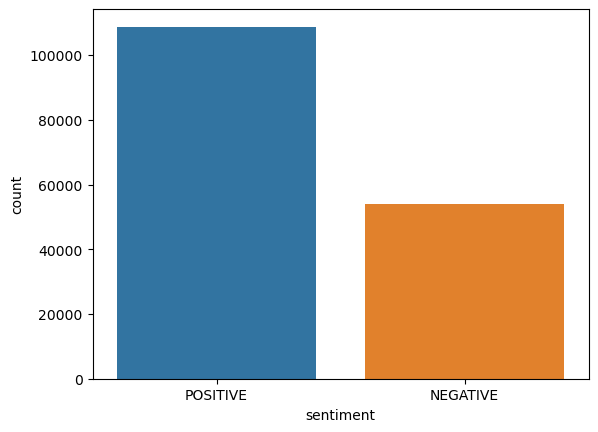

In [26]:
sns.countplot(x = 'sentiment',data = data)
sns.countplot(x = 'sentiment',data = merge)

In [27]:
# # WordCloud of all reviews on merge
# all_words=' '.join(text for text in merge['reviewText'])
# from wordcloud import WordCloud
# wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
# plt.figure(figsize=(6,6))
# plt.title('Merge reviews')
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()

# # WordCloud of all reviews
# all_words=' '.join(text for text in data['reviewText'])
# from wordcloud import WordCloud
# wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
# plt.figure(figsize=(6,6))
# plt.title('Train reviews')
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()

word cloud seems different for both

In [28]:
# # WordCloud of positive reviews on merge
# pos_words=' '.join([text for text in merge['reviewText'][merge['sentiment']=="POSITIVE"]])
# from wordcloud import WordCloud
# wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)
# plt.figure(figsize=(6,6))
# plt.title('Merge Positive reviews')
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()

# # WordCloud of positive reviews
# pos_words=' '.join([text for text in data['reviewText'][data['sentiment']=="POSITIVE"]])
# from wordcloud import WordCloud
# wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)
# plt.figure(figsize=(6,6))
# plt.title('Train Positive Reviews')
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()

In [29]:
# # WordCloud of negative reviews on merge
# neg_words=' '.join([text for text in merge['reviewText'][merge['sentiment']=="NEGATIVE"]])
# from wordcloud import WordCloud
# wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)
# plt.figure(figsize=(6,6))
# plt.title('Merge Negative Reviews')
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()


# # WordCloud of negative reviews 
# neg_words=' '.join([text for text in data['reviewText'][data['sentiment']=="NEGATIVE"]])
# from wordcloud import WordCloud
# wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)
# plt.figure(figsize=(6,6))
# plt.title('Train Negative Reviews')
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()

From Wordcloud , i can observe words are different after merging movies dataset.

in movie dataset sentiment column is not there due to which in train word positive words and negative words are more visible

In [30]:
# # Countplot for 'movieid' of Train data
# plt.figure(figsize=(6, 6))
# sns.countplot(x='movieid', data=data)
# plt.title('Count of Occurrences for each MovieID')
# plt.xlabel('MovieID')
# plt.ylabel('Count')
# plt.show()

# # Countplot for 'reviewerName' of Train data
# plt.figure(figsize=(6, 6))
# sns.countplot(x='reviewerName', data=data)
# plt.title('Count of Occurrences for each Reviewer Name')
# plt.xlabel('Reviewer Name')
# plt.ylabel('Count')
# plt.show()

most of the veviewer names are repeated , two reviewers are having count approx 600 maximum


In [31]:
# # Plotting histogram of audienceScore of merge
# plt.figure(figsize=(8, 6))
# sns.histplot(merge['audienceScore'].dropna(), bins=20, kde=True)
# plt.title('Audience Score Distribution')
# plt.xlabel('Audience Score')
# plt.ylabel('Count')
# plt.show()

# # Plotting scatter plot of audienceScore and runtimeMinutes of merge
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='audienceScore', y='runtimeMinutes', data=merge)
# plt.title('Audience Score vs. Runtime')
# plt.xlabel('Audience Score')
# plt.ylabel('Runtime (Minutes)')
# plt.show()

# # Plotting scatter plot of audienceScore and boxoffice of merge
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='audienceScore', y='boxOffice', data=merge)
# plt.title('Audience Score vs. box-office ')
# plt.xlabel('Audience Score')
# plt.ylabel('Box-Office')
# plt.show()

# # Plotting histogram of BoxOffice of merge
# plt.figure(figsize=(8, 6))
# sns.histplot(merge['boxOffice'], bins=20, kde=True)
# plt.title('Audience Score Distribution')
# plt.xlabel('Audience Score')
# plt.ylabel('Count')
# plt.show()


75-90 have most count in Audience Score

Runtime upto 200 covers most of the Audience Score

In [32]:
# merge['releaseDateTheaters'] = pd.to_datetime(merge['releaseDateTheaters'])
# plt.figure(figsize=(12, 6))
# sns.lineplot(x='releaseDateTheaters', y='audienceScore', data=merge)
# plt.title('Audience Score Trend by Release Date in Theaters')
# plt.xlabel('Release Date in Theaters')
# plt.ylabel('Audience Score')
# plt.xticks(rotation=45)
# plt.show()

# Data Pre-Processing on Merge data

In [33]:
drp_clm=['releaseDateTheaters','releaseDateStreaming','soundType','distributor']
merge = merge.drop(columns=drp_clm)
mer_ts = mer_ts.drop(columns=drp_clm)

In [34]:
merge['audienceScore'] = merge['audienceScore'].fillna(merge['audienceScore'].mean())
merge['runtimeMinutes'] = merge['runtimeMinutes'].fillna(merge['runtimeMinutes'].median())
merge['rating']= merge['rating'].fillna(merge['rating'].mode().iloc[0])
merge['ratingContents']=merge['ratingContents'].fillna(merge['ratingContents'].mode().iloc[0])
merge['genre']=merge['genre'].fillna(merge['genre'].mode().iloc[0])
merge['originalLanguage']=merge['originalLanguage'].fillna(merge['originalLanguage'].mode().iloc[0])

mer_ts['audienceScore'] = mer_ts['audienceScore'].fillna(mer_ts['audienceScore'].mean())
mer_ts['runtimeMinutes'] =mer_ts['runtimeMinutes'].fillna(mer_ts['runtimeMinutes'].median())
mer_ts['rating']= mer_ts['rating'].fillna(mer_ts['rating'].mode().iloc[0])
mer_ts['ratingContents']=mer_ts['ratingContents'].fillna(mer_ts['ratingContents'].mode().iloc[0])
mer_ts['genre']=mer_ts['genre'].fillna(mer_ts['genre'].mode().iloc[0])
mer_ts['originalLanguage']=mer_ts['originalLanguage'].fillna(mer_ts['originalLanguage'].mode().iloc[0])


In [35]:
# from sklearn.impute import SimpleImputer
# from sklearn.compose import ColumnTransformer

# #  SimpleImputer with strategy='most_frequent' for categorical columns
# #  SimpleImputer with strategy='mean' for numerical columns
# imputer_categorical = SimpleImputer(strategy='most_frequent')
# imputer_numerical = SimpleImputer(strategy='mean')

# #  ColumnTransformer with pipelines for different column types
# preprocess = ColumnTransformer(
#     transformers=[
#         ('numerical', Pipeline([('imputer', imputer_numerical)]),['audienceScore', 'runtimeMinutes']),
#         ('categorical', Pipeline([('imputer', imputer_categorical)]),['rating', 'ratingContents','genre','originalLanguage'])
#     ],
# )

# # Fit and transform the data using the preprocessing pipeline
# merge_trans = preprocess.fit_transform(merge)

# # convert the transformed data to a DataFrame
# column = ['reviewerName', 'isFrequentReviewer', 'reviewText', 'sentiment', 'title', 'audienceScore', 'rating', 'ratingContents']
# mrg_tran = pd.DataFrame(merge_trans, columns=columns)



(a) Text Cleaning

Firstly, to avoid the difference brought from case sensitivity, all words were transferred into lower case. Since the main feature required to be analyzed was the words conveying, punctuations and HTML tags were removed. In addition, some people may prefer to use punctuations as the emotion symbols, thus the emotion characters were remained and placed at the end of sentence.

In [36]:
#converting all object type column to clean text ie; in lower case with any symbol or puncuatuation marks
import re
def preprocessor(text):
    # Remove HTML tags
    text = re.sub('<[^>]*>', '', text)
    
    # Find and remove emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    
    # Remove non-word characters, including underscores
    text = re.sub('[\W_]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    
    return text


In [37]:
columns_to_preprocess = [
    'reviewText', 'reviewerName', 'title', 'rating', 'ratingContents',
    'genre', 'originalLanguage', 'director', 'movieid'
]

# Apply preprocessor to each column in the 'merge' DataFrame
for column in columns_to_preprocess:
    merge[column] = merge[column].apply(preprocessor)

# Apply preprocessor to each column in the 'mer_ts' DataFrame
for column in columns_to_preprocess:
    mer_ts[column] = mer_ts[column].apply(preprocessor)

b) Text tokenization is the important step in the NLP. It is a way of separating a piece of text into smaller units called tokens. In this project, token was the word extracted from the clear review which has been implemented data cleaning. 2 types of tokenization were tried in this project.

One was called tokenizer which just split the sentence into word.another is called stemmer which group similar word into the same group.

In [38]:
import re
def tokenizer(text):
    return text.split()
def stem(word):
    if word.endswith("ing"):
        return word[:-3]
    elif word.endswith("ed"):
        return word[:-2]
    elif word.endswith("ly"):
        return word[:-2]
    elif word.endswith("er"):
        return word[:-2]
    # Add more stemming rules as needed
    return word

def tokenizer_stemmer(text):
    return [stem(word) for word in text.split()]

In [39]:
mer_ts.head()

,movieid,reviewerName,isTopCritic,reviewText,title,audienceScore,rating,ratingContents,runtimeMinutes,genre,originalLanguage,director,boxOffice
0,legend marty mcfly oracle,john kim,False,green slowly cranks up the dread with style an...,legend marty mcfly oracle,57.000000,r,gore bloody horror violence language througho...,111.0,holiday horror mystery thriller,english,sara barnett,64.0
1,terminator katniss everdeen glimmer,brian chaney,False,philip noyce s direction is elegant and unforc...,terminator katniss everdeen glimmer,86.000000,pg,emotional thematic material,94.0,drama adventure,english,cindy flander,6.2
2,james bond labyrinth gollum,danielle parker,False,it wouldn t do to say what path maria ultimate...,james bond labyrinth gollum,62.000000,r,language,103.0,drama,french,charlotte bramble,0.0
3,v quest han solo wondrous,brittany lane,False,pig is not exactly the arthouse john wick that...,v quest han solo wondrous,84.000000,r,language,92.0,drama mystery thriller,english,jean gainer,3.1
4,enigma hulk surreal starlight,justin willis,False,an imaginative no budget musical of sorts abou...,enigma hulk surreal starlight,65.000179,r,language,66.0,drama musical,arabic,marvin short,0.0


In [40]:
merge.rating.unique()

array(['pg 13', 'r', 'pg', 'nc 17', 'tv14', 'tvpg', 'tvma'], dtype=object)

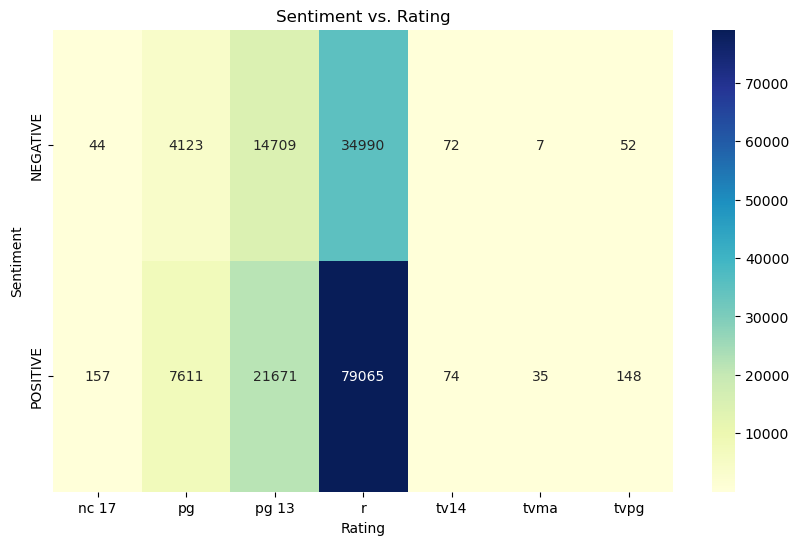

In [41]:
# Create a crosstab between sentiment and rating
crosstab_df = pd.crosstab(merge['sentiment'], merge['rating'])

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab_df, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Sentiment vs. Rating')
plt.xlabel('Rating')
plt.ylabel('Sentiment')
plt.show()

In [42]:
dtype_numerical = ['audienceScore','runtimeMinutes','boxOffice']
dtype_categorical = ['movieid','reviewerName',
                    'title',
                    'rating',
                    'ratingContents',
                    'genre',
                    'originalLanguage',
                    'director']

**Feature Engineering / preprocessing**

In [43]:
#converting categorical type column using hash function to transform in numeric value
for col in dtype_categorical:
    merge[col]=merge[col].apply(lambda x: hash(x) % (10**2))

In [44]:
#converting categorical type column using hash function to transform in numeric value
for col in dtype_categorical:
    mer_ts[col]=mer_ts[col].apply(lambda x: hash(x) % (10**2))

In [45]:
# Label Encoding for sentiment and isFrequentReviewer columns
label_encoder = LabelEncoder()
le = LabelEncoder()
merge['sentiment'] = label_encoder.fit_transform(merge['sentiment'])
merge['isFrequentReviewer'] = le.fit_transform(merge['isFrequentReviewer'])

# Label Encoding for sentiment and isFrequentReviewer columns

mer_ts['isTopCritic'] = le.fit_transform(mer_ts['isTopCritic'])


In [46]:
dtype_num = ['movieid','reviewerName','isFrequentReviewer','sentiment',
                    'title','audienceScore',
                    'rating',
                    'ratingContents','runtimeMinutes',
                    'genre',
                    'originalLanguage',
                    'director','boxOffice']

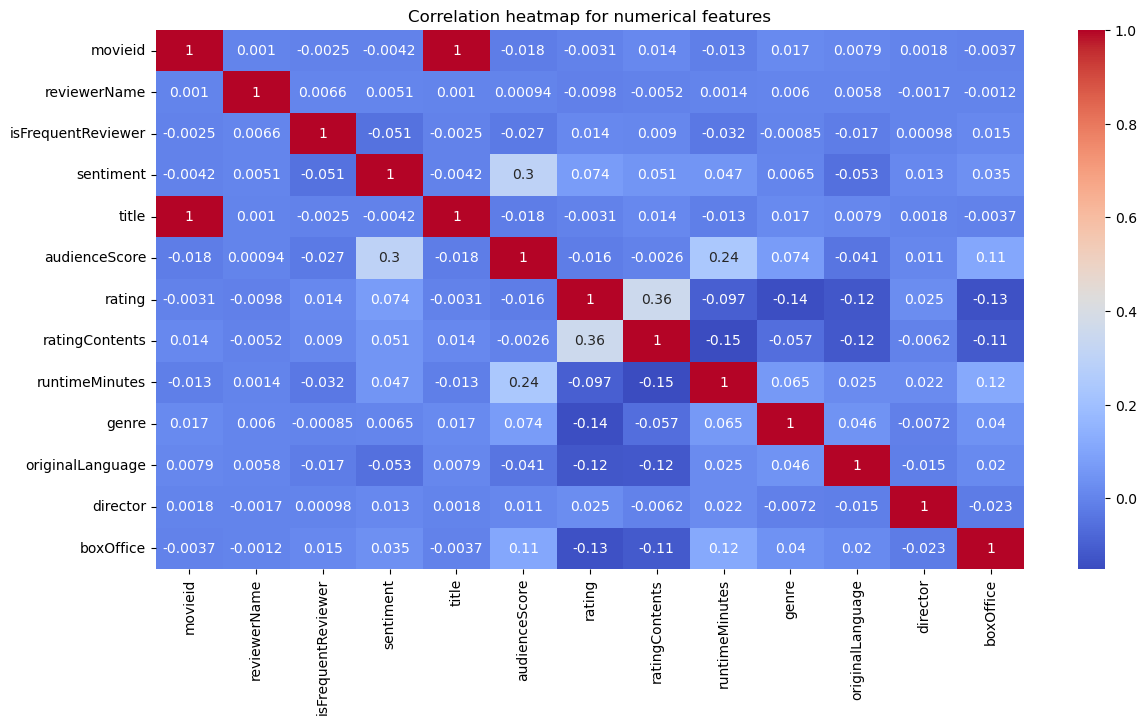

In [47]:
plt.figure(figsize=(14,7))

sns.heatmap(merge[dtype_num].corr(), cmap='coolwarm', annot=True)
plt.title("Correlation heatmap for numerical features")
plt.show()


**Clearly we can see sentiment has correlation with audiencescore only with 0.3 correlation**

In [48]:
# from sklearn.pipeline import FeatureUnion
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_extraction import FeatureHasher

# #scaling for numerical features
# num_pre = Pipeline([('scaler',StandardScaler())])
# #Hashing Vectorizer for categorical feature
# hasher = FeatureHasher(n_features=10, input_type='string')
# cat_pre = Pipeline([('hasher_encoding',FeatureHasher(n_features=10))])

# #tfidf for review text
# text_pre = Pipeline([('tfidf_vect',TfidfVectorizer())])
# #labelencoder for target column
# sent_pre = Pipeline([('encoder',LabelEncoder())])

# Preprocessor = ColumnTransformer(transformers=[('numerical',num_pre,dtype_numerical),
#                                              ('categorical',FeatureUnion([('hasher_encoding',cat_pre)]),dtype_categorical),
#                                              ('text',text_pre,'reviewText'),
#                                              ('target',sent_pre,'sentiment')],remainder='passthrough')
# X_pre=Preprocessor.fit(merge)
# x_pre=Preprocessor.transform(merge)

# X_pre_df = pd.DataFrame(x_pre)

In [49]:
X_merge = merge['reviewText']
y=merge['sentiment']

X_test = mer_ts['reviewText']

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer      # applying Tfidf Vectorizer for encoding
tfidf_vect =TfidfVectorizer(strip_accents=None,
                         lowercase=True,
                         preprocessor=None,  # Have applied preprocessor in Data Cleaning
                         tokenizer=tokenizer_stemmer,
                         use_idf=True,
                         norm='l2',
                         smooth_idf=True)
tfidf_vect = tfidf_vect.fit(X_merge)
X_tm = tfidf_vect.transform(X_merge)

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [51]:
#tfidf_vectt = tfidf_vect.fit(X_test)
X_ts = tfidf_vect.transform(X_test)

In [52]:
X_tm.shape,X_ts.shape

((162758, 57862), (55315, 57862))

In [53]:
au_tr  = merge[['audienceScore','runtimeMinutes','boxOffice','genre']]
au_ts  = mer_ts[['audienceScore','runtimeMinutes','boxOffice','genre']]

In [54]:
# Create a pipeline with StandardScaler
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Fit and transform the training data
pipe_tr = pipeline.fit_transform(au_tr)

# Transform the test data using the same scaler
pipe_ts = pipeline.transform(au_ts)

In [55]:
from scipy.sparse import hstack
# Stack scaled data with other sparse matrices
merged_data_tr = hstack([pipe_tr, X_tm])
merged_data_ts = hstack([pipe_ts, X_ts])

# Model1: Logistic Regression

In [56]:
# log_reg1 =LogisticRegression(C = 6.084,max_iter = 1000,penalty="l2",solver='liblinear',random_state=42)
# log_reg1.fit(merged_data_tr,y)
# y_pred = log_reg1.predict(merged_data_tr) 
# f1_score(y,y_pred,average="micro")

F1 score on merged data without tuning:0.84
on test : 0.81372


F1 score on merged data with tuning:0.8748
on test : 0.81527

# Hyperparameter tuning for logistic regression

In [57]:
# # Define the hyperparameter search space
# params = {'C': uniform(loc=0, scale=20),'penalty': ['l1', 'l2'],'solver': ['liblinear','saga'],'max_iter': [10000]}

# # applying model
# log_reg = LogisticRegression(random_state=42)

# #using randomsearch cv for hypertuning
# random_search1 = RandomizedSearchCV(log_reg,param_distributions=params, n_iter=10,cv =5, scoring='accuracy',n_jobs =1, random_state=42)
# random_search1.fit(merged_data_tr,y)

# #getting best estimator and parameter for log_reg
# best_model1 = random_search1.best_estimator_
# best_params1 = random_search1.best_params_

# #applying on train data
# y_pred1 = best_model1.predict(merged_data_tr)

# # Calculate the F1 score
# f1 = f1_score(y, y_pred1, average='micro')
# print("Best Hyperparameters:", best_params1)
# print("F1 Score:", f1)

Best Hyperparameters for logistic regression: {'C': 6.0848448591907545, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
F1 Score: 0.8819965838852776

In [58]:
# #applying confusion metrix
# cm1 = confusion_matrix(y,y_pred1)
# #visualisation of confusion matrix
# sns.heatmap(cm1,annot=True,cmap='Blues')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

In [59]:
# #printing classification report
# clf_report1 = classification_report(y, y_pred_labels)
# print(clf_report1)

# Best Model: LinearSVC

In [60]:
svm = LinearSVC(C=0.37, max_iter=10000, loss='squared_hinge',random_state=42,tol=0.001)
svm.fit(merged_data_tr, y)
y_pred2 = svm.predict(merged_data_tr)
f1 = f1_score(y, y_pred2, average="micro")

print("F1 score:", f1)

F1 score: 0.8676501308691431


without tuning: 0.86552 on test :0.81598
with tuning :0.8694,F1 score: 0.8714717556126275 with c = 0.334
test score: 0.81748




**Encluding more column like box office and genre increase the test score to 0.81759 while on train score was same**

# Hyperparameter tuning for LinearSVC

In [61]:
# ## Define the hyperparameter search space
# param_dist = {'C': uniform(loc=0, scale=1),'loss': ['hinge', 'squared_hinge'],'max_iter': [100000]}

#  # Create the Linear SVC model
# linear_svc = LinearSVC()

# # Perform random search cross-validation
# random_search2 = RandomizedSearchCV(linear_svc, param_distributions=param_dist, n_iter=10, scoring='f1_micro', random_state=42)
# random_search2.fit(merged_data_tr,y)

# # Get the best model and its hyperparameters
# best_model2 = random_search2.best_estimator_
# best_params2 = random_search2.best_params_

#  # Make predictions using the best model
# y_pred2 = best_model2.predict(merged_data_tr)

#  # Calculate the F1 score
# f1 = f1_score(y, y_pred2, average='micro')

#  # Print the best hyperparameters and F1 score
# print("Best Hyperparameters:", best_params2)
# print("F1 Score:", f1)

Best Hyperparameters: {'C': 0.33370861113902184, 'loss': 'squared_hinge', 'max_iter': 100000}
F1 Score: 0.8714471792477174

In [62]:
# #applying confusion metrix
# cm2 = confusion_matrix(y,y_pred2)
# #visualisation of confusion matrix
# sns.heatmap(cm2,annot=True,cmap='Blues')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

In [63]:
# #printing classification report
# clf_report2 = classification_report(y, y_pred2)
# print(clf_report2)

# Model3: Bagging Model

In [64]:

# # Create the base model (Logistic Regression)
# base_model = LogisticRegression(C=6, max_iter=1000, penalty='l2', solver='liblinear')

# # Create the Bagging classifier with Logistic Regression as the base model
# bagging_model = BaggingClassifier(base_model, n_estimators=14, random_state=52)

# # Train the Bagging classifier
# bagging_model.fit(merged_data_tr, y)
# y_pred5 = bagging_model.predict(merged_data_tr)

# # Evaluate the model using F1-score
# f1 = f1_score(y, y_pred5, average="micro")
# print("F1 Score:", f1)



F1 Score: 0.8672507649393578

# Hyperparameter tuning for Bagging Model

In [65]:
# # Create the base model (Logistic Regression)
# base_model = LogisticRegression(max_iter=1000)

# # Create the Bagging classifier with Logistic Regression as the base model
# bagging_model = BaggingClassifier(base_model, random_state=52)

# # Define the hyperparameters to sample from
# param_dist = {
#     'n_estimators': np.arange(5, 16),   # Number of base estimators in the ensemble (5 to 15)
#     'base_estimator__C': np.logspace(-3, 3, 7),  # C parameter of Logistic Regression (0.001 to 1000)
# }

# # Create the RandomizedSearchCV object
# random_search = RandomizedSearchCV(bagging_model, param_distributions=param_dist, n_iter=10, scoring='f1_micro', cv=5, random_state=42)

# # Train the RandomizedSearchCV to find the best hyperparameters
# random_search.fit(merged_data_tr, y)

# # Get the best estimator and its hyperparameters
# best_bagging_model = random_search.best_estimator_
# best_params = random_search.best_params_

# # Print the best hyperparameters
# print("Best Hyperparameters:", best_params)

# # Evaluate the best model on the test set
# y_pred3 = best_bagging_model.predict(merged_data_tr)
# f1 = f1_score(y, y_pred, average="micro")
# print("Best F1 Score:", f1)


In [66]:
# #printing classification report
# clf_report3 = classification_report(y, y_pred3)
# print(clf_report3)

In [67]:
#applying best model on test data
test_predictions=svm.predict(merged_data_ts)

# Submission

In [68]:
sample=pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv")#reading sample data
submission = pd.DataFrame(columns =['id','sentiment']) #submission
submission['id'] = [i for i in range(len(test_predictions))]
submission['sentiment'] = label_encoder.inverse_transform(test_predictions)
submission.to_csv('submission.csv', index = False)

# DATA PRE-PROCESSING on Train data

**HANDLING NULL VALUES**

In [69]:
# # Check for missing values in the 'reviewText' column
# missing_values = data.isnull().sum()
# print(f"Number of missing values in 'reviewText': {missing_values}")

In [70]:
# data['reviewText'].fillna(" ",inplace=True)

In [71]:
# #checking non null value in reviewText column
# non_null_values = data['reviewText'].notnull().sum()
# print(f"Number of non-null values in 'reviewText': {non_null_values}")

In [72]:
# #creating copy of train data
# data_cp = data.copy()
# data_cp.head()

In [73]:
# #applying preprocessor function to categorical column
# data_cp['movieid'] = data_cp['movieid'].apply(preprocessor)
# data_cp['reviewerName'] = data_cp['reviewerName'].apply(preprocessor)
# data_cp['reviewText'] = data_cp['reviewText'].apply(preprocessor)

In [74]:
# data_cp.head()#checking for changes

In [75]:
# #splitting label and feature column
# X=data_cp.drop(['sentiment'],axis=1)
# y=data_cp['sentiment']

In [76]:
# #converting object type column to numerical
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

# FEATURE RANKING

In [77]:
# #ordinalencoding on categorical variables
# cat_cols=X.select_dtypes(include=['object','bool']).columns
# encoder = OrdinalEncoder()
# X_encoded = pd.DataFrame(encoder.fit_transform(X[cat_cols]),columns=cat_cols)


In [78]:
# #using Recursive feature elimination to eliminate unnecessary column
# model = LogisticRegression()
# rfe = RFE(estimator=model,n_features_to_select=2)
# X_selected = rfe.fit_transform(X_encoded,y_encoded)
# feature_rankings = rfe.ranking_
# print("Feature Rankings:")
# for feature, rank in zip(X_encoded.columns, feature_rankings):
#     print(f"{feature}: {rank}")

on the basis of rfe we can remove isFrequentReviewver


In [79]:
# from sklearn.feature_selection import VarianceThreshold


# # Applying variance threshold feature selection
# var_threshold = VarianceThreshold(threshold=10000000)  
# X_selected = var_threshold.fit_transform(X_encoded,y_encoded)

# # Getting the selected feature indices
# selected_feature_indices = var_threshold.get_support(indices=True)

# # Getting the selected feature names
# selected_feature_names = X_encoded.columns[selected_feature_indices]

# # Print the selected feature_names
# print("Selected Features:")
# for feature in selected_feature_names:
#     print(feature)




on the basis of variance threshold we can remove reviewername

In [80]:
# k = 1
# selector = SelectKBest(score_func=chi2, k=k)
# X_selected = selector.fit_transform(X_encoded, y_encoded)
# selected_feature_indices = selector.get_support(indices=True)
# selected_feature_names = X_encoded.columns[selected_feature_indices]
# print("Selected Features:")
# for feature in selected_feature_names:
#     print(feature)

on the basis of selectKbest we can remove movieid


In [81]:
# #after feature selection taking only reviewtext as per ranking
# X_new = data_cp['reviewText']
# y_new = y_encoded

In [82]:
# from sklearn.feature_extraction.text import TfidfVectorizer      # applying Tfidf Vectorizer for encoding
# tfidf_vect =TfidfVectorizer()
# tfidf_vect = tfidf_vect.fit(X_new)
# X_tfidf = tfidf_vect.transform(X_new)

# #X_tfidf = pd.DataFrame(tfidf_X.toarray(), columns=tfidf_vect.get_feature_names_out())
# X_tfidf.shape

# Baseline Model

In [83]:
# from sklearn.dummy import DummyClassifier
# dc = DummyClassifier
# dummy_clf = dc(strategy = 'most_frequent')
# dummy_clf.fit(X_tfidf,y_new)
# y_pred = dummy_clf.predict(X_tfidf)
# dummy_clf.score(y_new,y_pred)

#  MODEL 1: LOGISTIC REGRESSION

In [84]:
# log_reg  =LogisticRegression(max_iter = 1000,random_state=42,solver = "liblinear",C = 3)
# log_reg.fit(X_tfidf,y_new)
# y_pred = log_reg.predict(X_tfidf)
# f1_score(y_new,y_pred,average="micro")

In [85]:
# log_reg  =LogisticRegression(max_iter = 1000,multi_class='multinomial',C=3,solver="saga")
# log_reg.fit(X_tfidf,y_new)
# y_pred = log_reg.predict(X_tfidf)
# f1_score(y_new,y_pred,average="micro")

0.8580223399157031

In [86]:
# pipe = Pipeline([('scaler',MaxAbsScaler()),('logreg',LogisticRegression(multi_class='multinomial',solver='sag'))])
# pipe.fit(X_tfidf,y_new)

In [87]:
# pipe = Pipeline([('scaler',MaxAbsScaler()),('logreg',LogisticRegressionCV(cv=5,multi_class='multinomial',solver='saga',max_iter=1000,random_state=1729))])
# pipe.fit(X_tfidf,y_new)

# hyperparameter tuning for log_reg

In [88]:
# # Define the hyperparameter search space
# params = {'C': uniform(loc=0, scale=20),'penalty': ['l1', 'l2'],'solver': ['liblinear','saga'],'max_iter': [1000]}

# # applying model
# log_reg = LogisticRegression(random_state=42)

# #using randomsearch cv for hypertuning
# random_search1 = RandomizedSearchCV(log_reg,param_distributions=params, n_iter=10,cv =5, scoring='accuracy',n_jobs =1, random_state=42)
# random_search1.fit(X_tfidf,y_new)

# #getting best estimator and parameter for log_reg
# best_model1 = random_search1.best_estimator_
# best_params1 = random_search1.best_params_

# #applying on train data
# y_pred1 = best_model1.predict(X_tfidf)

# # Calculate the F1 score
# f1 = f1_score(y_new, y_pred1, average='micro')
# print("Best Hyperparameters:", best_params1)
# print("F1 Score:", f1)

Best Hyperparameters: {'C': 6.0848448591907545, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
F1 Score: 0.8747281239631846


using random state 42

Best Hyperparameters: {'C': 3.0424224295953772, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
F1 Score: 0.8583111122033938

In [89]:
# #applying confusion metrix
# cm1 = confusion_matrix(y_new,y_pred)
# #visualisation of confusion matrix
# sns.heatmap(cm1,annot=True,cmap='Blues')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

In [90]:
# #printing classification report
# clf_report1 = classification_report(y_new, y_pred1)
# print(clf_report1)

# MODEL2 : SVM USING LINEAR SVC

In [91]:
# sv_clf = LinearSVC(random_state=52,C=0.18,max_iter=10000,loss='squared_hinge') #default svc model
# sv_clf.fit(X_tfidf,y_new)
# f1_score(y_new,sv_clf.predict(X_tfidf),average="micro")

0.8816893793239042

In [92]:
# # Polynomial Kernel
# svc=SVC(kernel="poly",probability=True)
# scores=scores=cross_val_score(svc,X_tfidf, y_new,scoring="accuracy",n_jobs=-1,cv=5) 
# print('Cross-validation mean accuracy {0:.2f}%'.format(np.mean(scores)*100))

In [93]:
# # RBF Kernel
# svc=SVC(kernel="rbf",probability=True)
# scores=scores=cross_val_score(svc,X_tfidf, y_new,scoring="accuracy",n_jobs=-1,cv=5) 
# print('Cross-validation mean accuracy {0:.2f}%'.format(np.mean(scores)*100))

In [94]:
# # Sigmoid Kernel
# svc=SVC(kernel="sigmoid",probability=True)
# scores=scores=cross_val_score(svc,X_tfidf, y_new,scoring="accuracy",n_jobs=-1,cv=5) 
# print('Cross-validation mean accuracy {0:.2f}%'.format(np.mean(scores)*100))

# Hyperparameter tuning  for svc

In [95]:
# ## Define the hyperparameter search space
# param_dist = {'C': uniform(loc=0, scale=1),'loss': ['hinge', 'squared_hinge'],'max_iter': [100000]}

#  # Create the Linear SVC model
# linear_svc = LinearSVC()

# # Perform random search cross-validation
# random_search2 = RandomizedSearchCV(linear_svc, param_distributions=param_dist, n_iter=10, scoring='f1_micro', random_state=42)
# random_search2.fit(X_tfidf,y_new)

# # Get the best model and its hyperparameters
# best_model2 = random_search2.best_estimator_
# best_params2 = random_search2.best_params_

#  # Make predictions using the best model
# y_pred2 = best_model2.predict(X_tfidf)

#  # Calculate the F1 score
# f1 = f1_score(y_new, y_pred2, average='micro')

#  # Print the best hyperparameters and F1 score
# print("Best Hyperparameters:", best_params2)
# print("F1 Score:", f1)

Best Hyperparameters: {'C': 0.1834347898661638, 'loss': 'squared_hinge', 'max_iter': 100000}
F1 Score: 0.847669546197422

In [96]:
# #applying confusion metrix
# cm2 = confusion_matrix(ytrain_balanced, y_pred2)
# #visualisation of confusion matrix
# sns.heatmap(cm2, annot=True, cmap='Blues')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

In [97]:
# #printing classification report
# clf_report2 = classification_report(ytrain_balanced, y_pred2)
# print(clf_report2)

# Model 3 Naive Bayes

In [98]:
# from sklearn.naive_bayes import MultinomialNB
# mnb=MultinomialNB()
# mnb.fit(X_tfidf,y_new)
# f1_score(y_new,mnb.predict(X_tfidf))

f1score on train 0.8630069517896216
score on text  0.7559

In [99]:
# from sklearn.naive_bayes import ComplementNB
# cnb = ComplementNB(force_alpha=True)
# cnb.fit(X_tfidf,y_new)
# f1_score(y_new,cnb.predict(X_tfidf))

f1 score on train : 0.8671993734324155
on test : 0.76

# Model 4:Bagging 

In [100]:

# # Create the base model (Logistic Regression)
# base_model = LogisticRegression(C=10, max_iter=1000, penalty='l2', solver='liblinear')

# # Create the Bagging classifier with Logistic Regression as the base model
# bagging_model = BaggingClassifier(base_model, n_estimators=14, random_state=52)

# # Train the Bagging classifier
# bagging_model.fit(X_tfidf,y_new)
# y_pred5 = bagging_model.predict(X_tfidf)

# # Evaluate the model using F1-score
# f1 = f1_score(y_new, y_pred5, average="micro")
# print("F1 Score:", f1)



F1 Score: 0.8700094619004903

# Hyperparametertuning for bagging classifier

Best Hyperparameters: {'n_estimators': 14, 'base_estimator__C': 10.0} #on smote set
Best F1 Score: 0.8014979552451408

Best Hyperparameters: {'n_estimators': 14, 'base_estimator__C': 10.0} #without smote
Best F1 Score: 0.8592757345261063

In [101]:
# # Create the base model (Logistic Regression)
# base_model = LogisticRegression(max_iter=1000)

# # Create the Bagging classifier with Logistic Regression as the base model
# bagging_model = BaggingClassifier(base_model, random_state=52)

# # Define the hyperparameters to sample from
# param_dist = {
#     'n_estimators': np.arange(5, 16),   # Number of base estimators in the ensemble (5 to 15)
#     'base_estimator__C': np.logspace(-3, 3, 7),  # C parameter of Logistic Regression (0.001 to 1000)
# }

# # Create the RandomizedSearchCV object
# random_search = RandomizedSearchCV(bagging_model, param_distributions=param_dist, n_iter=10, scoring='f1_micro', cv=5, random_state=42)

# # Train the RandomizedSearchCV to find the best hyperparameters
# random_search.fit(X_tfidf,y_new)

# # Get the best estimator and its hyperparameters
# best_bagging_model = random_search.best_estimator_
# best_params = random_search.best_params_

# # Print the best hyperparameters
# print("Best Hyperparameters:", best_params)

# # Evaluate the best model on the test set
# y_pred = best_bagging_model.predict(X_tfidf)
# f1 = f1_score(y_new, y_pred, average="micro")
# print("Best F1 Score:", f1)


In [102]:
# #applying confusion metrix
# cm5 = confusion_matrix(y_test,y_pred5)
# #visualisation of confusion matrix
# sns.heatmap(cm5,annot=True,cmap='Blues')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

In [103]:
# #printing classification report
# clf_report5 = classification_report(y_test, y_pred5)
# print(clf_report)

# Model5:Decision Tree


In [104]:
# from sklearn.tree import DecisionTreeClassifier
# dt = DecisionTreeClassifier(criterion='gini',max_depth=3,min_samples_split=12,min_samples_leaf=6)
# dt.fit(X_tfidf,y_new)
# y_pred4 = dt.predict(X_tfidf)
# f1_score(y_new,y_pred4,average="micro")

on train: 0.9847012128436083

on test : 0.69774

with tuning on train :0.7171567603435776
on test : 0.69811

# hyperparameter tuning for DecisionTree

In [105]:
# from scipy.stats import randint

# # Define the hyperparameter distribution
# param_dist = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': randint(5, 50),
#     'min_samples_split': randint(2, 30),
#     'min_samples_leaf': randint(1,10)
# }

# # Create the RandomizedSearchCV object
# random_search4 = RandomizedSearchCV(dt, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=1, random_state=52)

# # Fit the RandomizedSearchCV to the data
# random_search4.fit(X_tfidf,y_new)

# #getting best estimator and parameter for log_reg
# best_model4 = random_search4.best_estimator_
# best_params4 = random_search4.best_params_

# #applying on train data
# y_pred4 = best_model4.predict(X_tfidf)

# # Calculate the F1 score
# f1 = f1_score(y_new, y_pred4, average='micro')
# print("Best Hyperparameters:", best_params4)
# print("F1 Score:", f1)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 37, 'min_samples_leaf': 6, 'min_samples_split': 12}
F1 Score: 0.7170338785190282

In [106]:
# #applying confusion metrix
# cm4 = confusion_matrix(y_test,y_pred4)
# #visualisation of confusion matrix
# sns.heatmap(cm4,annot=True,cmap='Blues')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

In [107]:
# #printing classification report
# clf_report4 = classification_report(y_test, y_pred4)
# print(clf_report4)

# Multilayerperceptron

In [108]:
# mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)
# mlp_model.fit(Xtrain_balanced,ytrain_balanced)
# y_pred6 =mlp_model.predict(Xtest_balanced)
# f1_score(y_test,y_pred6,average="micro")

# XGBoostClassifier 

In [109]:
# from xgboost import XGBClassifier
# xgb = XGBClassifier()
# xgb.fit(Xtrain_balanced,ytrain_balanced)
# y_pred5 = dt.predict(X_test)
# f1_score(y_test,y_pred4,average="micro")

# **MODEL: KNN**

In [110]:
#from sklearn.neighbors import KNeighborsClassifier

In [111]:
#knc = KNeighborsClassifier()

In [112]:
#knc.fit(Xtrain_balanced,ytrain_balanced)
#f1_score(ytrain_balanced,knc.predict(Xtrain_balanced),average="micro")

**HYPERPARAMETER TUNING**

In [113]:
#param_dist = {'n_neighbors': randint(low=1, high=20),'weights': ['uniform', 'distance'],'p': [1, 2]}

In [114]:
#knn = KNeighborsClassifier()
#random_search3 = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=10, scoring='f1_micro', random_state=42)
#random_search3.fit(Xtrain_balanced, ytrain_balanced)

In [115]:
#best_model3 = random_search3.best_estimator_
#best_params3 = random_search3.best_params_

In [116]:
#y_pred3 = best_model3.predict(Xtrain_balanced)

In [117]:
#f1 = f1_score(ytrain_balanced, y_pred3, average='micro')
#print("Best Hyperparameters:", best_params)
#print("F1 Score:", f1)

# feature scaling using pipeline

In [118]:
# from sklearn.preprocessing import PolynomialFeatures,StandardScaler,MaxAbsScaler,RobustScaler

In [119]:
#from sklearn.pipeline import Pipeline
#from sklearn.decomposition import TruncatedSVD

#ss_pipe = Pipeline([("std_scaler",StandardScaler(with_mean=False)),
 #                   ("svd",TruncatedSVD(n_components=99,random_state=52)),
  #                  ('log_reg',LogisticRegression(random_state=52,max_iter=1000))])

#mx_pipe = Pipeline([("mx_pipe",MaxAbsScaler()),
                      #("svd",TruncatedSVD(n_components=99,random_state=52)),
                      #('log_reg',LogisticRegression(random_state=52,max_iter=1000))])

#rc_pipe = Pipeline([("std_scaler",RobustScaler(with_centering=False)),
                    #("svd",TruncatedSVD(n_components=99,random_state=52)),
                    #('log_reg',LogisticRegression(random_state=52,max_iter=1000))])'''


**Model with StandardScaler**

In [120]:
#ss_pipe.fit(Xtrain_balanced,ytrain_balanced)
#f1_score(ytrain_balanced,ss_pipe.predict(Xtrain_balanced),average="micro"),
#f1_score(ytest_balanced,ss_pipe.predict(Xtest_balanced),average="micro")'''


**Model with MaxAbsScaler**

In [121]:
#mx_pipe.fit(Xtrain_balanced,ytrain_balanced)
#f1_score(ytrain_balanced,mx_pipe.predict(Xtrain_balanced),average="micro"),
#f1_score(ytest_balanced,mx_pipe.predict(Xtest_balanced),average="micro")'''


**Model with Robust Scaler**

In [122]:
#rc_pipe.fit(Xtrain_balanced,ytrain_balanced)
#f1_score(ytrain_balanced,rc_pipe.predict(Xtrain_balanced),average="micro"),
#f1_score(ytest_balanced,rc_pipe.predict(Xtest_balanced),average="micro")'''


**Hyperparameter tuning using grid search CV** 

In [123]:
#from sklearn.model_selection import GridSearchCV

#param_grid = {'log_reg__penalty':['l2'],'log_reg__C': [0.1, 1, 10]}'''

In [124]:
#gs_cv = GridSearchCV(rc_pipe, param_grid, cv=5)''''''

In [125]:
#gs_cv.fit(Xtrain_balanced,ytrain_balanced)

In [126]:
#tuned_log = gs_cv.best_estimator_
#tuned_log.fit(Xtrain_balanced, ytrain_balanced)
#f1_score(ytrain_balanced,tuned_log.predict(Xtrain_balanced),average="micro"),
#f1_score(ytest_balanced,tuned_log.predict(Xtest_balanced),average="micro")'''


# voting classifier

In [127]:
# clf1 = LogisticRegression(random_state=52,max_iter = 1000)
# clf2 = LinearSVC(random_state=52)
# clf3 = GaussianNB()
# eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
# for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Ensemble']):
#     scores = cross_val_score(clf,X_tfidf,y_new, scoring='accuracy', cv=5)
#     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
# eclf.fit(X_tfidf,y_new)
# predictions = eclf.predict(X_tfidf)


In [128]:
# from sklearn.linear_model import SGDClassifier
# from sklearn.metrics import log_loss, f1_score
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import MaxAbsScaler

# # Define your SGDClassifier with appropriate parameters
# estimator = SGDClassifier(loss='log', penalty='l2', max_iter=1, warm_start=True, alpha=0, eta0=0.5, learning_rate='constant', random_state=10)

# # Create a pipeline with the estimator and MaxAbsScaler for sparse data
# pipe_sgd = make_pipeline(MaxAbsScaler(), estimator)

# Loss = []
# F1_scores = []
# iterations = 40

# for i in range(iterations):
#     # Fit the pipeline to the training data
#     pipe_sgd.fit(merged_data_tr, y)
    
#     # Predict probabilities using the trained model
#     y_pred_proba = pipe_sgd.predict_proba(merged_data_tr)
    
#     # Calculate and append log loss
#     loss = log_loss(y, y_pred_proba)
#     Loss.append(loss)
    
#     # Predict labels and calculate F1 score
#     y_pred_labels = pipe_sgd.predict(merged_data_tr)
#     f1 = f1_score(y, y_pred_labels)
#     F1_scores.append(f1)

#     print(f"Iteration {i+1}: Log Loss = {loss:.4f}, F1 Score = {f1:.4f}")

# print("Log Loss:", Loss)
# print("F1 Scores:", F1_scores)



In [129]:
# plt.figure()
# plt.plot(np.arange(iterations), Loss)
# plt.grid(True)
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.show()

In [130]:
# from sklearn.model_selection import cross_val_score

# # Define a range of learning rates to test
# learning_rates = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

# # Create lists to store mean F1 scores for each learning rate
# mean_f1_scores = []

# for lr in learning_rates:
#     # Create the SGDClassifier with the specified learning rate
#     estimator = SGDClassifier(loss='hinge', penalty='l1', max_iter=50, warm_start=True, alpha=0, eta0=lr, learning_rate='constant', random_state=10)
#     pipe_sgd = make_pipeline(MaxAbsScaler(), estimator)
    
#     # Perform cross-validation and get F1 scores
#     f1_scores = cross_val_score(pipe_sgd, merged_data_tr, y, cv=5, scoring='f1')
    
#     # Calculate the mean F1 score across all folds for this learning rate
#     mean_f1 = np.mean(f1_scores)
#     mean_f1_scores.append(mean_f1)

# # Find the learning rate with the highest mean F1 score
# best_learning_rate = learning_rates[np.argmax(mean_f1_scores)]
# print("Best Learning Rate:", best_learning_rate)


In [131]:
# from sklearn.model_selection import cross_val_score

# # Define a range of alpha values to test
# alpha_values = [0.001, 0.01, 0.1, 1, 10]

# # Create lists to store mean F1 scores for each alpha
# mean_f1_scores = []

# for alpha in alpha_values:
#     # Create the SGDClassifier with the specified alpha value
#     estimator = SGDClassifier(loss='hinge', penalty='l1', max_iter=50, warm_start=True, alpha=alpha, eta0=0.5, learning_rate='constant', random_state=10)
#     pipe_sgd = make_pipeline(MaxAbsScaler(), estimator)
    
#     # Perform cross-validation and get F1 scores
#     f1_scores = cross_val_score(pipe_sgd, merged_data_tr, y, cv=5, scoring='f1')
    
#     # Calculate the mean F1 score across all folds for this alpha
#     mean_f1 = np.mean(f1_scores)
#     mean_f1_scores.append(mean_f1)

# # Find the alpha with the highest mean F1 score
# best_alpha = alpha_values[np.argmax(mean_f1_scores)]
# print("Best Alpha:", best_alpha)


In [132]:
# from sklearn.linear_model import SGDClassifier
# from sklearn.metrics import log_loss, f1_score
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import MaxAbsScaler

# # Define your SGDClassifier with appropriate parameters
# estimator = SGDClassifier(loss='squared_hinge',penalty='l2', max_iter=1000, warm_start=True, alpha=0, eta0=0.01, learning_rate='constant', random_state=42)

# # Create a pipeline with the estimator and MaxAbsScaler for sparse data
# pipe_sgd = make_pipeline(MaxAbsScaler(), estimator)
# # Fit the pipeline to the training data
# pipe_sgd.fit(merged_data_tr, y)
# y_pred_labels = pipe_sgd.predict(merged_data_tr)
# f1 = f1_score(y, y_pred_labels)
# print("F1 Score:", f1)

F1 Score: 0.9264134363647893

In [133]:
# from sklearn.linear_model import SGDClassifier
# from sklearn.metrics import log_loss, f1_score
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import MaxAbsScaler

# # Define your SGDClassifier with appropriate parameters
# estimator = SGDClassifier(loss='log', penalty='l2', max_iter=10, warm_start=True, alpha=0, eta0=0.001, learning_rate='constant', random_state=10)

# # Create a pipeline with the estimator and MaxAbsScaler for sparse data
# pipe_sgd = make_pipeline(MaxAbsScaler(), estimator)
# # Fit the pipeline to the training data
# pipe_sgd.fit(merged_data_tr, y)
# y_pred_labels = pipe_sgd.predict(merged_data_tr)
# f1 = f1_score(y, y_pred_labels)
# print("F1 Score:", f1)

for l2 best alpha is 0.001 and learning rate is 0.01 F1 Score: 0.8227459600276793

for l1 best alpha is 0.1and learning rate is 0.01 F1 Score: 0.8011299393412615